In [185]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

plt.style.use('fivethirtyeight')
#os.chdir("/mydir")

In [128]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [129]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [130]:
df = combined_csv.copy()

In [131]:
df.head(2)

,鄉鎮市區,交易標的,土地位置建物門牌,土地移轉總面積平方公尺,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易年月日,交易筆棟數,移轉層次,總樓層數,建物型態,主要用途,主要建材,建築完成年月,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,建物現況格局-隔間,有無管理組織,總價元,單價元平方公尺,車位類別,車位移轉總面積(平方公尺),車位總價元,備註,編號,主建物面積,附屬建物面積,陽台面積,電梯,移轉編號
0,The villages and towns urban district,transaction sign,land sector position building sector house num...,land shifting total area square meter,the use zoning or compiles and checks,the non-metropolis land use district,non-metropolis land use,transaction year month and day,transaction pen number,shifting level,total floor number,building state,main use,main building materials,construction to complete the years,building shifting total area,Building present situation pattern - room,building present situation pattern - hall,building present situation pattern - health,building present situation pattern - compartme...,Whether there is manages the organization,total price NTD,the unit price (NTD / square meter),the berth category,berth shifting total area square meter,the berth total price NTD,the note,serial number,NaN,NaN,NaN,NaN,NaN
1,文山區,房地(土地+建物),臺北市文山區指南路二段４５巷１０弄７號二樓,25.44,住,NaN,NaN,1041005,土地1建物1車位0,二層,五層,公寓(5樓含以下無電梯),住家用,鋼筋混凝土造,0701231,107.4,3,2,2,有,無,11800000,109870,NaN,0.0,0,NaN,RPUQMLPJJIKFFAA67CA,80.43,0.0,12.58,NaN,NaN


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142058 entries, 0 to 6129
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   鄉鎮市區           142058 non-null  object 
 1   交易標的           142058 non-null  object 
 2   土地位置建物門牌       142058 non-null  object 
 3   土地移轉總面積平方公尺    142058 non-null  object 
 4   都市土地使用分區       140672 non-null  object 
 5   非都市土地使用分區      43 non-null      object 
 6   非都市土地使用編定      24 non-null      object 
 7   交易年月日          142058 non-null  object 
 8   交易筆棟數          142058 non-null  object 
 9   移轉層次           127180 non-null  object 
 10  總樓層數           126979 non-null  object 
 11  建物型態           142058 non-null  object 
 12  主要用途           123596 non-null  object 
 13  主要建材           127229 non-null  object 
 14  建築完成年月         114826 non-null  object 
 15  建物移轉總面積平方公尺    142058 non-null  object 
 16  建物現況格局-房       142058 non-null  object 
 17  建物現況格局-廳       142058 non-null 

In [133]:
df = df.drop([0])

In [134]:
# dropped 土地位置建物門牌, 非都市土地使用分區, 非都市土地使用編定, 車位類別,
# 車位總價元, 備註, 編號, 電梯, 移轉編號
df.drop(df.columns[[2,5,6,23,25,26,27,31,32]], axis = 1, inplace = True)

In [135]:
#df['建築完成年月'].isnull().sum() = 26278 so there should be at least 70k values
# length is 135598 - 26278 = 109,320 values that aren't null?
#df['建築完成年月'].value_counts() = 9763 unique values
# no way to figure out if dates can be repairable?
# if we wanted all real estate transactions with build dates, dropping NA is the only way
df['建築完成年月'].dropna(inplace = True)

In [136]:
df.dropna(inplace = True)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106914 entries, 1 to 6128
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   鄉鎮市區           106914 non-null  object 
 1   交易標的           106914 non-null  object 
 2   土地移轉總面積平方公尺    106914 non-null  object 
 3   都市土地使用分區       106914 non-null  object 
 4   交易年月日          106914 non-null  object 
 5   交易筆棟數          106914 non-null  object 
 6   移轉層次           106914 non-null  object 
 7   總樓層數           106914 non-null  object 
 8   建物型態           106914 non-null  object 
 9   主要用途           106914 non-null  object 
 10  主要建材           106914 non-null  object 
 11  建築完成年月         106914 non-null  object 
 12  建物移轉總面積平方公尺    106914 non-null  object 
 13  建物現況格局-房       106914 non-null  object 
 14  建物現況格局-廳       106914 non-null  object 
 15  建物現況格局-衛       106914 non-null  object 
 16  建物現況格局-隔間      106914 non-null  object 
 17  有無管理組織         106914 non-null 

In [138]:
df.reset_index(drop = True, inplace = True)

In [139]:
new_tester = df['建築完成年月']
# look for weird dates in build date
weird = []
for i in range(len(new_tester)):
  if len(new_tester.iloc[i]) < 6:
    weird.append(i)

# 14 weird values with build date length < 6
# incomprehensible dates so remove
new_tester[weird]

3089     05807
10303    07002
21705      031
26570    06212
32318    05305
36670    05701
41933      034
49900    06212
53764    07306
73082      049
76690    05807
78469      018
85677      030
96841    04410
Name: 建築完成年月, dtype: object

In [140]:
# there shouldn't be double digit month other than 10 11 12
df.drop(weird, axis = 0, inplace=True)
# reset index so when removing other rows will be more tidy
df.reset_index(drop = True, inplace = True)

In [141]:
# look for weird spaces (dates shouldn't have spaces here)
# 10148 should be removed
new_tester = df['建築完成年月']
new_tester[new_tester.str.contains(' ') == True]
#new_tester[new_tester.str.contains('076  03') == True]

61603    076  03
Name: 建築完成年月, dtype: object

In [142]:
df.drop(df[df['建築完成年月'].str.contains('076  03') == True].index, axis = 0, inplace = True)

In [143]:
# change TW date into normal date format
for i in range(len(df['建築完成年月'])):
  df['建築完成年月'].iloc[i] = str(int(df['建築完成年月'].iloc[i]) + 19110000)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [144]:
df['建築完成年月'] = pd.to_datetime(df['建築完成年月'])

In [145]:
# look for weird date patterns in transaction date
# values that are < 6
new_tester = df['交易年月日']
weird = []
for i in range(len(new_tester)):
  if len(new_tester.iloc[i]) < 6:
    weird.append(i)

df['交易年月日'][weird]

Series([], Name: 交易年月日, dtype: object)

In [146]:
new_tester[new_tester.str.contains(' ') == True]

Series([], Name: 交易年月日, dtype: object)

In [147]:
# look for weird 0000 patterns
df['交易年月日'][df['交易年月日'].str.contains('0000') == True]

93507    1090000
Name: 交易年月日, dtype: object

In [148]:
df.drop(df[df['交易年月日'].str.contains('1090000') == True].index, axis = 0, inplace = True)

In [149]:
for i in range(len(df['交易年月日'])):
  df['交易年月日'].iloc[i] = str(int(df['交易年月日'].iloc[i]) + 19110000)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [150]:
df['交易年月日'] = pd.to_datetime(df['交易年月日'])

In [151]:
df.reset_index(drop = True, inplace = True)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106898 entries, 0 to 106897
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   鄉鎮市區           106898 non-null  object        
 1   交易標的           106898 non-null  object        
 2   土地移轉總面積平方公尺    106898 non-null  object        
 3   都市土地使用分區       106898 non-null  object        
 4   交易年月日          106898 non-null  datetime64[ns]
 5   交易筆棟數          106898 non-null  object        
 6   移轉層次           106898 non-null  object        
 7   總樓層數           106898 non-null  object        
 8   建物型態           106898 non-null  object        
 9   主要用途           106898 non-null  object        
 10  主要建材           106898 non-null  object        
 11  建築完成年月         106898 non-null  datetime64[ns]
 12  建物移轉總面積平方公尺    106898 non-null  object        
 13  建物現況格局-房       106898 non-null  object        
 14  建物現況格局-廳       106898 non-null  object        
 15  

In [153]:
df.iloc[:,[2,12,13,14,15,18,19,20]] = df.iloc[:,[2,12,13,14,15,18,19,20]].apply(pd.to_numeric)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106898 entries, 0 to 106897
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   鄉鎮市區           106898 non-null  object        
 1   交易標的           106898 non-null  object        
 2   土地移轉總面積平方公尺    106898 non-null  float64       
 3   都市土地使用分區       106898 non-null  object        
 4   交易年月日          106898 non-null  datetime64[ns]
 5   交易筆棟數          106898 non-null  object        
 6   移轉層次           106898 non-null  object        
 7   總樓層數           106898 non-null  object        
 8   建物型態           106898 non-null  object        
 9   主要用途           106898 non-null  object        
 10  主要建材           106898 non-null  object        
 11  建築完成年月         106898 non-null  datetime64[ns]
 12  建物移轉總面積平方公尺    106898 non-null  float64       
 13  建物現況格局-房       106898 non-null  int64         
 14  建物現況格局-廳       106898 non-null  int64         
 15  

In [155]:
# removing price and price per sqft from features
# storing them into own separate columns
y = df.iloc[:,18]
price_per_sqft = df.iloc[:,19]
df.drop(df.iloc[:,[18,19]], axis = 1, inplace = True)

In [156]:
# change column names to english to prevent boxes in graphs
eng_col = ['district', 'transaction type', 'land shifting total area sqm', 'zoning', 'transaction date', 'transaction pen no', 'floor', 'building floor total', 
           'building state', 'main use', 'main building materials', 'build date', 'building shifting total area', 'building situation - room', 'building situation - hall', 
           'building situation - bath', 'building situation - compartment', 'management committee', 'parking sqm', 'main building area', 
           'ancilliary building area', 'balcony area']
df.columns = eng_col

In [157]:
# replacing CN to EN categories for district
replacers = {'文山區':'Wenshan District', '中山區':'Zhongshan District', '中正區':'Zhongzheng District', '信義區':'Xinyi District', '內湖區':'Neihu District', '北投區':'Beitou District', 
             '南港區':'Nangang District', '士林區': 'Shilin District', '大同區':'Datong District', '大安區':'Daan District', '文山區':'Wenshan District', '萬華區':'Wanhua District',
             '松山區':'Songshan District'}
df['district'] = df['district'].replace(replacers)

In [158]:
# replacing CN to EN for transaction type
replacers = {'房地(土地+建物)':'land and building', '房地(土地+建物)+車位':'land and building and parking', '建物':'building'}
df['transaction type'] = df['transaction type'].replace(replacers)

In [159]:
# replacing building floor total
# may need to come back and change int to str
# it's currently int64 after replacing?
replacers = {'一層':1, '二層':2, '三層':3, '四層':4, '五層':5, '六層':6, '七層':7, '八層':8,'九層':9,'十層':10,'十一層':11, '十二層':12, '十三層':13, '十四層':14, '十五層':15, '十六層':16, '十七層':17, '十八層':18, '十九層':19,
             '二十層':20, '二十一層':21, '二十二層':22, '二十三層':23, '二十四層':24, '二十五層':25, '二十六層':26, '二十七層':27, '二十八層':28, '二十九層':29, '三十層':30, '三十一層':31, '三十二層':32, '三十三層':33, '三十四層':34,
             '三十五層':35,'三十六層':36,'三十七層':37,'三十八層':38,'三十九層':39,'四十層':40,'四十一層':41,'四十二層':42}
df['building floor total'] = df['building floor total'].replace(replacers)

In [160]:
# too many types of zones, so for urban others, can shove everything into just urban others
df['zoning'][df['zoning'].str.contains('都市：其他')==True] = '都市：其他'
# replacing CN to EN for zoning
replacers = {'住':'residential', '商':'commercial', '其他':'other', '工':'industrial', '都市：其他':'urban:other', '都市：商':'urban:commercial', '都市：住':'urban:residential', '非都市： ; 非都市編定：':'non-urban', '農':'farm'}
df['zoning'] = df['zoning'].replace(replacers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [161]:
# replacing building situation - compartment from CN to EN
replacers = {'有':'Yes', '無':'No'}
df['building situation - compartment'] = df['building situation - compartment'].replace(replacers)

In [162]:
# replacing CN to EN for management committee
replacers = {'有':'Yes', '無':'No'}
df['management committee'] = df['management committee'].replace(replacers)

In [163]:
# simplified transactions with multiple floor deals?
# may lose information
for i in range(len(df['floor'])):
  if len(df['floor'].iloc[i].split('，')) > 1:
    df['floor'].iloc[i] = 'More than 1 Floor'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [164]:
# replacing CN to EN for floor
# given above we have 'More than 1 floor', changed everything to str
replacers = {'一層':1, '二層':2, '三層':3, '四層':4, '五層':5, '六層':6, '七層':7, '八層':8,'九層':9,'十層':10,'十一層':11, '十二層':12, '十三層':13, '十四層':14, '十五層':15, '十六層':16, '十七層':17, '十八層':18, '十九層':19,
             '二十層':20, '二十一層':21, '二十二層':22, '二十三層':23, '二十四層':24, '二十五層':25, '二十六層':26, '二十七層':27, '二十八層':28, '二十九層':29, '三十層':30, '三十一層':31, '三十二層':32, '三十三層':33, '三十四層':34,
             '三十五層':35,'三十六層':36,'三十七層':37,'三十八層':38,'三十九層':39,'四十層':40,'四十一層':41,'四十二層':42, '防空避難室':'Bomb Shelter', '地下層':'Basement', '地下一層':'B1', '地下二層':'B2', '地下三層':'B3',
             '地下四層':'B4','地下五層':'B5','屋頂突出物':'Rooftop item','見使用執照': 'Other', '見其他登記事項':'Other', '全':'Other', '夾層':'Other'}
df['floor'] = df['floor'].replace(replacers)
df['floor'] = df['floor'].astype(str)

In [165]:
# replacing CN to EN for building state
# high-rise, apartment, condo,
# administrative office in factory, townhouse, other, commercial
# Somewhat INCOMPLETE
replacers = {'住宅大樓(11層含以上有電梯)': 'Residential Building (11F+ w/ Elevator)', '公寓(5樓含以下無電梯)':'Apartment (Within 5F or lower w/o Elevator)', 
             '華廈(10層含以下有電梯)':'Apartment (within 10F w/ Elevator)', '廠辦':'Admin office in Factory', '透天厝':'Townhouse', '其他':'Other', '店面(店鋪)':'Storefront',
             '套房(1房1廳1衛)':'Suite', '辦公商業大樓':'Commercial Building'}
df['building state'] = df['building state'].replace(replacers)

In [166]:
df.drop(['main use'], axis = 1, inplace = True)

In [167]:
# change transaction pen no into a string like \d , \d, \d
# then split using delimiter into diff columns to count number of units of land, building and parking
# replacer = {'土地':'', '建物':',', '車位':','}
# for i in range(len(df['transaction pen no']):

# df['transaction pen no'].replace(replacers)
# for i in range(len(df['transaction pen no'])):
#   replacers = {'土地':'', '建物':',', '車位':','}
#   df['transaction pen no'] = df['transaction pen no'].iloc[i].replace(replacers)
df['transaction pen no'] = df['transaction pen no'].str.replace('土地', '')
df['transaction pen no'] = df['transaction pen no'].str.replace('建物', ',')
df['transaction pen no'] = df['transaction pen no'].str.replace('車位', ',')
df['transaction land units'] = df['transaction pen no'].str.split(',', expand=True)[0]
df['transaction building units'] = df['transaction pen no'].str.split(',', expand=True)[1]
df['transaction parking units'] = df['transaction pen no'].str.split(',', expand=True)[2]
df.drop(['transaction pen no'], axis = 1, inplace = True)

In [168]:
# replacing CN to EN categories for main buildling materials
# prestressed concrete = PC
# 鋼筋混凝土結構造 =? 鋼骨鋼筋混凝土造 =? 鋼筋混凝土造
# INCOMPLETE
replacers = {'鋼筋混凝土造':'RC', '鋼骨':'SC', '加強磚造':'RB', '鋼骨鋼筋混凝土造':'SRC', '鋼骨鋼筋混凝土造；鋼骨造':'SRC;RC', '磚造':'B', '預力混凝土造':'PC', 
             '鋼骨混凝土造':'SRC', '土磚石混合造':'C+B', '木石磚造(雜木)':'W', '鋼筋混凝土結構造':'RC', '鋼筋混凝土加強磚造': 'RC + B', '鋼造':'S', '壁式預鑄鋼筋混凝土造':'Wall Precast RC',
             '鋼構造':'S', '加強石造':'Reinforced Stone', '見其他登記事項':'Other', '鋼骨ＲＣ造':'SRC', '見使用執照':'Other', '鋼骨造':'S', '木造':'W', '石造':'Stone', '混凝土造':'RC',
             '木石磚造（雜木）':'W', '土造':'C'}
df['main building materials'] = df['main building materials'].replace(replacers)

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106898 entries, 0 to 106897
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   district                          106898 non-null  object        
 1   transaction type                  106898 non-null  object        
 2   land shifting total area sqm      106898 non-null  float64       
 3   zoning                            106898 non-null  object        
 4   transaction date                  106898 non-null  datetime64[ns]
 5   floor                             106898 non-null  object        
 6   building floor total              106898 non-null  int64         
 7   building state                    106898 non-null  object        
 8   main building materials           106898 non-null  object        
 9   build date                        106898 non-null  datetime64[ns]
 10  building shifting total area    

In [170]:
df.iloc[:,[20, 21, 22]] = df.iloc[:,[20, 21, 22]].apply(pd.to_numeric)

In [171]:
df['build year'] = pd.DatetimeIndex(df['build date']).year

In [172]:
# this returns 1 copy of the duplicates
df[df.duplicated() == True]

,district,transaction type,land shifting total area sqm,zoning,transaction date,floor,building floor total,building state,main building materials,build date,building shifting total area,building situation - room,building situation - hall,building situation - bath,building situation - compartment,management committee,parking sqm,main building area,ancilliary building area,balcony area,transaction land units,transaction building units,transaction parking units,build year
2,Zhongzheng District,land and building,0.02,residential,2015-09-14,Other,1,Townhouse,RB,1951-01-09,0.02,0,0,1,No,No,0.00,0.00,0.00,0.00,1,1,0,1951
3,Zhongzheng District,land and building,0.02,residential,2015-09-14,Other,1,Townhouse,RB,1951-01-09,0.02,0,0,1,No,No,0.00,0.00,0.00,0.00,1,1,0,1951
4,Zhongzheng District,land and building,0.02,residential,2015-09-14,Other,1,Townhouse,RB,1951-01-09,0.02,0,0,1,No,No,0.00,0.00,0.00,0.00,1,1,0,1951
5,Zhongzheng District,land and building,0.02,residential,2015-09-14,Other,1,Townhouse,RB,1951-01-09,0.02,0,0,1,No,No,0.00,0.00,0.00,0.00,1,1,0,1951
6,Zhongzheng District,land and building,0.02,residential,2015-09-14,Other,1,Townhouse,RB,1951-01-09,0.02,0,0,1,No,No,0.00,0.00,0.00,0.00,1,1,0,1951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105814,Daan District,land and building and parking,5.51,residential,2015-10-28,5,14,Residential Building (11F+ w/ Elevator),RC,2018-04-12,79.83,0,0,0,No,Yes,35.97,24.22,0.00,3.82,2,1,1,2018
106258,Daan District,land and building,29.43,commercial,2018-04-26,6,6,Apartment (within 10F w/ Elevator),RC,1984-07-11,157.64,3,2,2,Yes,No,0.00,132.22,0.00,17.10,1,1,0,1984
106320,Zhongshan District,land and building and parking,20.90,commercial,2018-07-17,3,7,Apartment (within 10F w/ Elevator),RC,2018-05-01,120.76,2,2,1,Yes,Yes,19.97,49.35,7.28,5.26,2,1,1,2018
106362,Neihu District,land and building and parking,20.57,other,2014-03-08,24,29,Residential Building (11F+ w/ Elevator),Other,2018-02-23,308.37,0,0,0,No,No,58.20,144.96,6.71,18.10,1,1,2,2018


In [173]:
df['price'] = y
# getting ride of duplicates
df = df.drop_duplicates()

In [174]:
# done cleaning and sorting?
df2 = df.copy()

In [175]:
# year was the numerical issue, causing log to not work
df2['build year'] = df2['build year'].astype(str)

In [176]:
# only returns numerical 
print("Find most important features relative to target")
corr = df2.corr()
corr.sort_values(["price"], ascending = False, inplace = True)
print(corr.price)

Find most important features relative to target
price                           1.000000
main building area              0.920958
building shifting total area    0.880721
land shifting total area sqm    0.680014
balcony area                    0.555493
transaction parking units       0.526987
transaction building units      0.350647
parking sqm                     0.267165
ancilliary building area        0.144773
building floor total            0.101992
building situation - bath       0.057016
building situation - room       0.041191
transaction land units          0.008026
building situation - hall      -0.002497
Name: price, dtype: float64


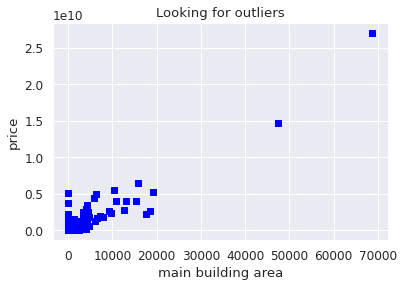

In [177]:
plt.scatter(df2['main building area'], df2['price'], c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("main building area")
plt.ylabel("price")
plt.show()

df2 = df2[df2['main building area'] < 25000]

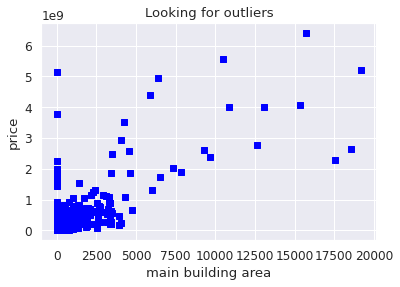

In [178]:
plt.scatter(df2['main building area'], df2['price'], c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("main building area")
plt.ylabel("price")
plt.show()

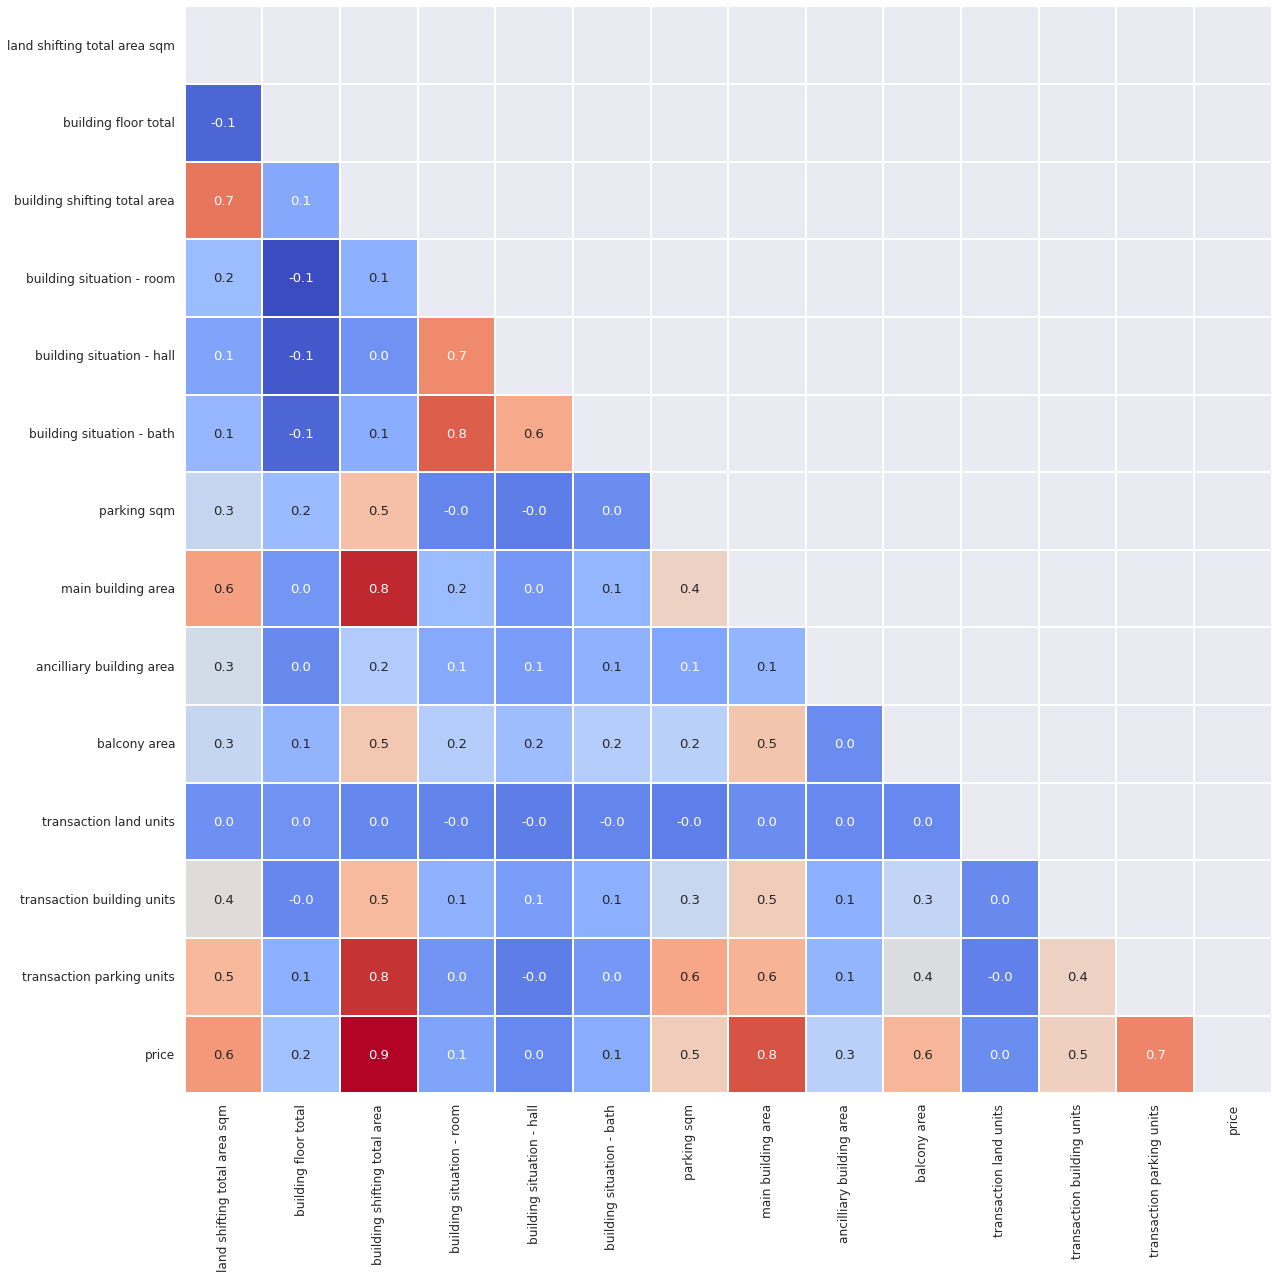

In [179]:
# Display numerical correlations (pearson) between features on heatmap.

sns.set(font_scale=1.1)
correlation_train = df2.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

In [190]:
# can convert into bins?
# keep recent ones and create other bins
# 30+ years, 20-29 years old, 10-19 years old, more recent ones are their own category?
df2['build year'].value_counts().head(20)

2016    4573
2015    4085
1981    3719
1984    3461
1983    3431
2017    3351
2018    3327
2008    3285
2019    2943
1980    2819
2020    2756
1982    2736
1985    2556
1978    2446
1979    2413
2009    2391
2007    2336
1986    2251
1977    2243
2014    2105
Name: build year, dtype: int64

In [191]:
replacers = {'1919':'Before 2000', '1920':'Before 2000', '1921':'Before 2000', '1922':'Before 2000', '1923':'Before 2000', '1924':'Before 2000', '1925':'Before 2000',
             '1926':'Before 2000', '1927':'Before 2000', '1928':'Before 2000', '1929':'Before 2000', '1930':'Before 2000', '1931':'Before 2000', '1932':'Before 2000',
             '1933':'Before 2000', '1934':'Before 2000', '1935':'Before 2000', '1936':'Before 2000', '1937':'Before 2000', '1938':'Before 2000', '1939':'Before 2000',
             '1940':'Before 2000', '1941':'Before 2000', '1942':'Before 2000', '1943':'Before 2000', '1944':'Before 2000', '1945':'Before 2000', '1946':'Before 2000', '1947':'Before 2000',
       '1948':'Before 2000', '1949':'Before 2000', '1950':'Before 2000', '1951':'Before 2000', '1952':'Before 2000', '1953':'Before 2000', '1954':'Before 2000', '1955':'Before 2000',
       '1956':'Before 2000', '1957':'Before 2000', '1958':'Before 2000', '1959':'Before 2000', '1960':'Before 2000', '1961':'Before 2000', '1962':'Before 2000', '1963':'Before 2000',
       '1964':'Before 2000', '1965':'Before 2000', '1966':'Before 2000', '1967':'Before 2000', '1968':'Before 2000', '1969':'Before 2000', '1970':'Before 2000', '1971':'Before 2000',
       '1972':'Before 2000', '1973':'Before 2000', '1974':'Before 2000', '1975':'Before 2000', '1976':'Before 2000', '1977':'Before 2000', '1978':'Before 2000', '1979':'Before 2000',
       '1980':'Before 2000', '1981':'Before 2000', '1982':'Before 2000', '1983':'Before 2000', '1984':'Before 2000', '1985':'Before 2000', '1986':'Before 2000', '1987':'Before 2000',
       '1988':'Before 2000', '1989':'Before 2000', '1990':'Before 2000', '1991':'Before 2000', '1992':'Before 2000', '1993':'Before 2000', '1994':'Before 2000', '1995':'Before 2000',
       '1996':'Before 2000', '1997':'Before 2000', '1998':'Before 2000', '1999':'Before 2000', '2000':'2000-2010', '2001':'2000-2010', '2002':'2000-2010', '2003':'2000-2010',
       '2004':'2000-2010', '2005':'2000-2010', '2006':'2000-2010', '2007':'2000-2010', '2008':'2000-2010', '2009':'2000-2010', '2010':'2000-2010'}
df2['build year'] = df2['build year'].replace(replacers)

In [192]:
df2['build year'].unique()

array(['Before 2000', '2000-2010', '2015', '2014', '2013', '2012', '2011',
       '2017', '2020', '2019', '2016', '2018', '2021'], dtype=object)

In [193]:
replacers = {'11':'11-20', '12':'11-20', '13':'11-20', '14':'11-20', '15':'11-20', '16':'11-20', '17':'11-20', '18':'11-20', '19':'11-20', '20':'11-20',
             '21':'Above 20', '22':'Above 20', '23':'Above 20', '24':'Above 20', '25':'Above 20', '26':'Above 20', '27':'Above 20', '28':'Above 20', '29':'Above 20',
             '30':'Above 20', '31':'Above 20', '32':'Above 20', '33':'Above 20', '34':'Above 20', '35':'Above 20', '36':'Above 20', '37':'Above 20', '38':'Above 20', 
             '39':'Above 20', '40':'Above 20', '41':'Above 20', '42':'Above 20', '43':'Above 20', '44':'Above 20', '45':'Above 20', '46':'Above 20', '47':'Above 20',
             '48':'Above 20', '49':'Above 20', 'B1':'Other', 'B2':'Other', 'B3':'Other', 'B4':'Other', 'B5':'Other', 'Basement':'Other', 'Bomb Shelter':'Other', 'Rooftop item':'Other'}
df2['floor'] = df2['floor'].replace(replacers)

In [194]:
# maybe can do 1 to 10
# More than 1 floor by itself
# shove everything else to others?
df2['floor'].value_counts()

11-20                12979
4                    12705
3                    12265
2                    11088
5                    10659
6                     7017
More than 1 Floor     6525
7                     6496
1                     6240
8                     4877
9                     4496
10                    3955
Other                 2190
Above 20              1028
Name: floor, dtype: int64

In [195]:
# keep top 10 numerical based on correlation. parking spot price removed b/c of overlap with parking sqm and 
# how bargaining may affect the pricing.
categorical_features = df2.select_dtypes(include = ["object"]).columns
numerical_features = df2.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop(['transaction date', 'build date', 'price'])
# let's try dropping build year and floor
# these are causing problems
# An increase in the dimensionality of the dataset causes curses of dimensionality, which leads to the problem of parallelism and multicollinearity.
#categorical_features = categorical_features.drop(['build year', 'floor'])
#categorical_features = categorical_features.drop(['floor'])

In [196]:
categorical_features

Index(['district', 'transaction type', 'zoning', 'floor', 'building state',
       'main building materials', 'building situation - compartment',
       'management committee', 'build year'],
      dtype='object')

In [197]:
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = df2[numerical_features]
df_cat = df2[categorical_features]

Numerical features : 13
Categorical features : 9


In [210]:
def srt_box(y, df):
    
    '''A function for displaying categorical variables.'''
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 20))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['object']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=90)
        j.yaxis.set_major_locator(MaxNLocator(nbins=5))

        plt.tight_layout()

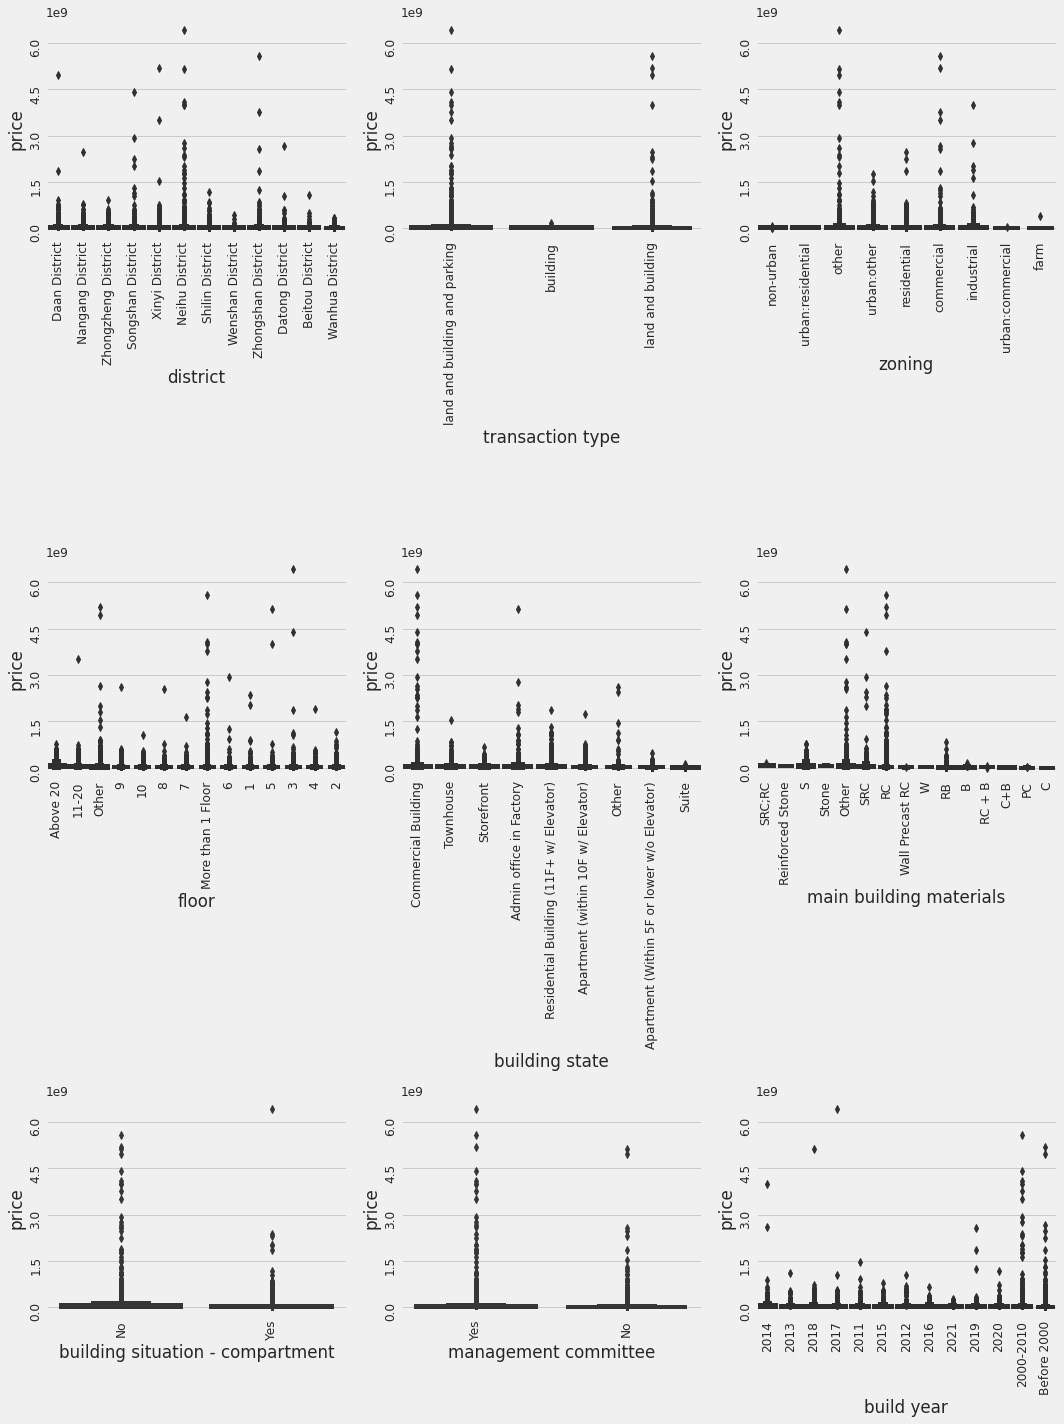

In [211]:
srt_box('price', df2)

In [212]:
# 'district','transaction type', 'zoning', 'building state', 'main building materials', 'building situation - compartment', 'management committee'
# are the categorical ones that are ok

## Testing modeling with only numerical values to see if log normalizing works.
* numerical values work, only year was the problem.
* maybe make years into categorical bins

In [213]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = df_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
df_num[skewed_features] = np.log1p(df_num[skewed_features])

13 skewed numerical features to log transform


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [214]:
df2.price = np.log1p(df.price)
y = df2.price

In [215]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(df_cat.isnull().values.sum()))
df_cat = pd.get_dummies(df_cat)
print("Remaining NAs for categorical features in train : " + str(df_cat.isnull().values.sum()))

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0


In [216]:
# Join categorical and numerical features
# df_num is now log-normalized, categorical is not though
train = pd.concat([df_num, df_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 92
X_train : (71764, 92)
X_test : (30756, 92)
y_train : (71764,)
y_test : (30756,)


In [217]:
## took out of modeling b/c not sure if reversible to predict pricing

# # Standardize numerical features
# # Standardization cannot be done before the partitioning, as we don't want to fit the StandardScaler on some observations that will later be used in the test set.
# stdSc = StandardScaler()
# X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
# X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

In [218]:
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8685810575761325

In [219]:
model = Ridge()
parameters = {'alpha':[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]}
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
ridge = GridSearchCV(model, parameters, cv=cv, return_train_score=False)
ridge.fit(X_train, y_train)
print(ridge.best_params_)
print(ridge.best_score_)

{'alpha': 6}
0.8605210421835963


In [220]:
#UserWarning: X has feature names, but Ridge was fitted without feature names f"X has feature names, but {self.__class__.__name__} was fitted without
# was because didn't use .values
best_ridge_model = ridge.best_estimator_
best_ridge_model.fit(X_train.values, y_train.values)
best_ridge_model.score(X_test.values, y_test.values)

0.8687015374773148

In [221]:
model = Lasso()
parameters = {'alpha':[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60], 
              'selection': ['random', 'cyclic'], 
              'max_iter':[5000]}
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
lasso = GridSearchCV(model, parameters, cv=cv, return_train_score=False)
lasso.fit(X_train, y_train)
print(lasso.best_params_)
print(lasso.best_score_)

{'alpha': 0.01, 'max_iter': 5000, 'selection': 'random'}
0.8257414815021701


In [222]:
best_lasso_model = lasso.best_estimator_
best_lasso_model.fit(X_train, y_train)
best_lasso_model.score(X_test, y_test)

0.8337179977989455

In [223]:
model = ElasticNet()
parameters = {'alpha':[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60], 
              'l1_ratio': [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
              'max_iter':[5000]}
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
enet = GridSearchCV(model, parameters, cv=cv, return_train_score=False)
enet.fit(X_train, y_train)
print(enet.best_params_)
print(enet.best_score_)

{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 5000}
0.8525526315534849


In [224]:
best_enet_model = enet.best_estimator_
best_enet_model.fit(X_train, y_train)
best_enet_model.score(X_test, y_test)

0.8607139988297396

In [225]:
np.where(train.columns == 'build year_2011')[0][0]

80

In [226]:
# log1p of numerical inputs
def predict_price(lstasqm, floortotal, bsta, bsr, bsh, bsb, parksqm, mainba, ancba, balc, tlu, tbu, tpu, by, district, transtype, zoning, floor, buildingstate, materials, bsc, manage):
  buildyear_index = np.where(train.columns == by)[0][0]
  district_index = np.where(train.columns == district)[0][0]
  transtype_index = np.where(train.columns == transtype)[0][0]
  zoning_index = np.where(train.columns == zoning)[0][0]
  floor_index = np.where(train.columns == floor)[0][0]
  bs_index = np.where(train.columns == buildingstate)[0][0]
  materials_index = np.where(train.columns == materials)[0][0]
  bsc_index = np.where(train.columns == bsc)[0][0]
  manage_index = np.where(train.columns == manage)[0][0]
  
  x = np.zeros(len(train.columns))
  x[0] = np.log1p(lstasqm)
  x[1] = np.log1p(floortotal)
  x[2] = np.log1p(bsta)
  x[3] = np.log1p(bsr)
  x[4] = np.log1p(bsh)
  x[5] = np.log1p(bsb)
  x[6] = np.log1p(parksqm)
  x[7] = np.log1p(mainba)
  x[8] = np.log1p(ancba)
  x[9] = np.log1p(balc)
  x[10] = np.log1p(tlu)
  x[11] = np.log1p(tbu)
  x[12] = np.log1p(tpu)

  #setting district_index = 1
  if buildyear_index >= 0:
    x[buildyear_index] = 1
  if district_index >= 0:
    x[district_index] = 1
  if transtype_index >= 0:
    x[transtype_index] = 1
  if zoning_index >= 0:
    x[zoning_index] = 1
  if floor_index >= 0:
    x[floor_index] = 1
  if bs_index >= 0:
    x[bs_index] = 1
  if materials_index >= 0:
    x[materials_index] = 1
  if bsc_index >= 0:
    x[bsc_index] = 1
  if manage_index >= 0:
    x[manage_index] = 1

  return  np.expm1(best_ridge_model.predict([x])[0])
  

In [227]:
predict_price(8.65, 13, 41, 1, 1, 1, 0, 26, 0.7, 0, 1, 1, 0, 'build year_2011', 'district_Wenshan District', 'transaction type_land and building', 'zoning_urban:other', 
              'floor_8', 'building state_Apartment (within 10F w/ Elevator)', 'main building materials_SRC', 'building situation - compartment_Yes', 
              'management committee_Yes')


7754402.143001726

In [228]:
# model export
import pickle
with open('tw_home_price_model.pickle', 'wb') as f:
  pickle.dump(best_ridge_model, f)

In [229]:
# column exports
import json
columns = {
    'data_columns' : [col.lower() for col in train.columns]
}
with open('columns.json', 'w') as f:
  f.write(json.dumps(columns))